In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor


In [127]:
mass = pd.read_csv('../data/mass_mobile.csv')
#mass = pd.read_pickle('../data/02b_added_prosperity.pickle')

#mass = pd.read_pickle('../data/03_dummy_df.pickle')

# infile = open('../data/03_dummy_df.pickle','r')
# mass = pickle.load(infile)
# infile.close()

mass.head(3)

,Unnamed: 0,id,country,ccode,region,protestnumber,protesterviolence,location,protesteridentity,sources,...,social_restrictions,start_date,end_date,target,notes_clean,neg,neu,pos,compound,protest_duration
0,0,201990001,Canada,20,North America,1,0.0,national,unspecified,1. great canadian train journeys into history;...,...,0,1990-01-15,1990-01-15,"[0, 0, 0, 0, 1, 0, 0]",canada s railway passenger system was finally ...,0.087,0.913,0.000,-0.8176,1
1,1,201990002,Canada,20,North America,2,0.0,"Montreal, Quebec",unspecified,1. autonomy s cry revived in quebec the new yo...,...,0,1990-06-25,1990-06-25,"[0, 0, 0, 0, 1, 0, 0]",protestors were only identified as young peopl...,0.000,1.000,0.000,0.0000,1
2,2,201990003,Canada,20,North America,3,0.0,"Montreal, Quebec",separatist parti quebecois,1. quebec protest after queen calls for unity ...,...,0,1990-07-01,1990-07-01,"[0, 0, 0, 0, 1, 0, 0]","the queen, after calling on canadians to remai...",0.060,0.830,0.109,0.7003,1


In [128]:
mass.drop('Unnamed: 0', axis=1, inplace=True)

In [134]:
mass['target'][0]

'[0, 0, 0, 0, 1, 0, 0]'

In [46]:
mass.groupby(['accomodation','arrests']).count()

id  country  ccode  region  protestnumber  \
accomodation arrests                                                 
0            0        11660    11660  11660   11660          11660   
             1         1998     1998   1998    1998           1998   
1            0         1376     1376   1376    1376           1376   
             1          145      145    145     145            145   

                      protesterviolence  location  protesteridentity  sources  \
accomodation arrests                                                            
0            0                    11660     11642              11660    11656   
             1                     1998      1997               1998     1998   
1            0                     1376      1374               1376     1376   
             1                      145       145                145      145   

                      notes  ...  social_restrictions  start_date  end_date  \
accomodation arrests         ...                                              
0            0        11660  ...                11660       11660     11660   
             1         1998  ...                 1998        1998      1998   
1            0         1376  ...                 1376        1376      1376   
             1          145  ...                  145         145       145   

                      target  notes_clean    neg    neu    pos  compound  \
accomodation arrests                                                       
0            0         11660        11660  11660  11660  11660     11660   
             1          1998         1998   1998   1998   1998      1998   
1            0          1376         1376   1376   1376   1376      1376   
             1           145          145    145    145    145       145   

                      protest_duration  
accomodation arrests                    
0            0                   11660  
             1                    1998  
1            0                    1376  
             1                     145  

[4 rows x 232 columns]

In [47]:
mass.arrests.value_counts()

0    13036
1     2143
Name: arrests, dtype: int64

In [48]:
protest_cats = pd.DataFrame(mass.protest_size_category.value_counts())
protest_cats

,protest_size_category
100-999,4730
"1,000-4,999",3881
50-99,3485
"10,000-100,000",2113
"5,000-9,999",576
"Over 100,000",369
Less than 50,25


In [49]:


ordered_categories = ['Less than 50', '50-99', '100-999', '1,000-4,999',  '5,000-9,999', '10,000-100,000', 'Over 100,000', ]

protest_cats = pd.DataFrame(mass.protest_size_category.value_counts())
protest_cats = protest_cats.reindex(ordered_categories)

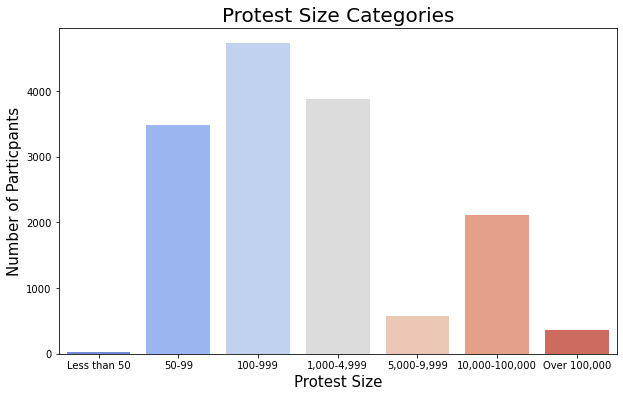

In [50]:
ordered_categories = ['Less than 50', '50-99', '100-999', '1,000-4,999',  '5,000-9,999', '10,000-100,000', 'Over 100,000', ]

protest_cats = pd.DataFrame(mass.protest_size_category.value_counts())
protest_cats = protest_cats.reindex(ordered_categories)

fig_dims = (10, 6)
fig, ax = plt.subplots(figsize=fig_dims)


ax = sns.barplot(x=protest_cats.index, y = 'protest_size_category' , data=protest_cats, ax=ax, palette='coolwarm')

ax.set_title("Protest Size Categories",fontsize=20)
ax.set_xlabel("Protest Size",fontsize=15)
ax.set_ylabel("Number of Particpants",fontsize=15)
ax.tick_params(labelsize=10)



In [51]:
#mass['participants'].isnull().sum()

In [52]:
#mass.info(verbose=True)

In [53]:
mass.columns[0:20]

Index(['id', 'country', 'ccode', 'region', 'protestnumber',
       'protesterviolence', 'location', 'protesteridentity', 'sources',
       'notes', 'protester_id_type', 'partipants_number',
       'protest_size_category', 'pop_male', 'pop_female', 'pop_total',
       'pop_density', 'prosperity_2020', 'country_Afghanistan',
       'country_Albania'],
      dtype='object')

In [152]:
#list(mass.columns[18:183])

In [55]:
mass.iloc[5:15][['partipants_number','compound','region_Europe','arrests','accomodation','beatings']]

,partipants_number,compound,region_Europe,arrests,accomodation,beatings
5,200,-0.9690,0,0,0,0
6,110000,-0.0772,0,0,0,0
7,110000,-0.2023,0,0,0,0
8,1000,-0.4310,0,1,0,0
9,10000,0.8834,0,0,0,0
10,100,-0.9022,0,1,0,0
11,10000,0.6486,0,0,0,0
12,6000,-0.6869,0,0,0,0
13,3000,-0.6968,0,0,0,0
14,100,-0.9713,0,0,0,0


In [56]:
features_1 = mass.drop(columns=['country', 'ccode', 'region', 'location','protesteridentity', 'sources',
       'notes', 'protester_id_type', 'protest_size_category', 'start_date', 'notes_clean', 'neg', 'neu', 'pos',
       'end_date', 'target', 'arrests', 'accomodation', 'beatings',
       'crowddispersal', 'ignore', 'killings', 'shootings'])

In [57]:
features = ['pop_density', 'prosperity_2020','partipants_number','compound','region_Europe','region_Central America','region_Africa',
'region_MENA', 'region_North America', 'region_Oceania', 'region_South America']

#X = mass[features_1]
X = features_1
y = np.array(mass[['arrests', 'accomodation', 'beatings',
       'crowddispersal', 'ignore', 'killings', 'shootings']])

y

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]], dtype=int64)

In [97]:
#features_1.info(verbose=True)

In [59]:
len(X)

15179

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [61]:
# pipe_forest = Pipeline([
#         ('regressor', MultiOutputRegressor(RandomForestClassifier() ) ) ] )

# param_grid = {#'regressor__min_samples_split':[10, 50],
#               #'regressor__min_samples_leaf':[50, 150],
#              #'regressor__max_features': [5,20,70],
#               'regressor__bootstrap': [True, False]      
#              }

# #random_forest = RandomForestClassifier()
# gs = GridSearchCV(estimator=pipe_forest, param_grid=param_grid)

# gs.fit(X_train,y_train)

In [62]:


model_grad_booster = MultiOutputClassifier(GradientBoostingClassifier())

model_random_forest = MultiOutputClassifier(RandomForestClassifier())  

# This chunk for random forest model
hyperparameters_forest = dict(estimator__learning_rate=[0.05, 0.1, 0.2, 0.5, 0.9],
                       estimator__n_estimators=[20, 50, 100, 200, 300, 500, 1000],
                       estimator__min_samples_split=[2, 4, 7, 10],
                       estimator__max_depth=[3, 5, 10, 15, 20, 30],
                       estimator__min_samples_leaf=[1, 2, 3, 5, 8, 10],
                       estimator__min_impurity_decrease=[0, 0.2, 0.4, 0.6, 0.8],
                       estimator__max_leaf_nodes=[5, 10, 20, 30, 50, 100, 300])

# This chunck is for GradientBoostingClassifier - grid search
hyperparameters_grad = dict(estimator__learning_rate=[ 0.2, 0.5], 
                     estimator__n_estimators=[20, 50, 100],
                     #  estimator__min_samples_split=[2, 4, 7, 10],
                     estimator__max_depth=[5, 20, 30], 
                   # estimator__min_samples_leaf=[ 5, 8, 10],
                    # estimator__min_impurity_decrease=[0.2, 0.6, 0.8],
                     estimator__max_leaf_nodes=[5, 20, 100])

randomized_search = RandomizedSearchCV(model_random_forest, hyperparameters_forest,
                                       n_jobs=-1, cv=5, verbose=1,
                                       error_score='raise')

# grid_search = GridSearchCV(model_grad_booster, hyperparameters_grad,n_jobs=-1, cv=5, verbose=True,
#                                        pre_dispatch='2*n_jobs', error_score='raise', return_train_score=True)


hyperparameters_tuning = randomized_search.fit(X_train, y_train)

#hyperparameters_tuning = grid_search.fit(X_train, y_train)

print('Best Parameters = {}'.format(hyperparameters_tuning.best_params_))

tuned_model = hyperparameters_tuning.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 32.2min finished


Best Parameters = {'estimator__n_estimators': 50, 'estimator__min_samples_split': 10, 'estimator__min_samples_leaf': 8, 'estimator__min_impurity_decrease': 0.6, 'estimator__max_leaf_nodes': 300, 'estimator__max_depth': 5, 'estimator__learning_rate': 0.05}


In [73]:
tuned_y_preds = tuned_model.predict(X_train_sc)
#tuned_y_preds = np.round(tuned_y_preds)

In [123]:
tuned_y_preds[0:6]

array([[0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0]], dtype=int64)

In [110]:
tuned_y_preds.shape

(11384, 7)

In [125]:
mass['target']

0        [0, 0, 0, 0, 1, 0, 0]
1        [0, 0, 0, 0, 1, 0, 0]
2        [0, 0, 0, 0, 1, 0, 0]
3        [0, 1, 0, 0, 0, 0, 0]
4        [1, 1, 0, 1, 0, 0, 0]
                 ...          
15174    [0, 0, 0, 1, 0, 0, 1]
15175    [0, 0, 0, 1, 0, 1, 1]
15176    [0, 1, 0, 0, 0, 0, 0]
15177    [0, 0, 0, 1, 0, 0, 0]
15178    [0, 0, 0, 0, 1, 0, 0]
Name: target, Length: 15179, dtype: object

In [126]:
y_train[0:5]

array([[0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1]], dtype=int64)

In [76]:
y_train.shape

(11384, 7)

In [77]:
y_train[0:3]

array([[0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 0]], dtype=int64)

In [78]:
X_train.shape

(11384, 211)

In [79]:
tuned_model.score(X_train_sc, y_train )

0.584328882642305

In [80]:
tuned_model.score(X_test_sc, y_test)

0.5594202898550724

In [140]:
# Baseline:
mass['target'].value_counts(normalize=True)

[0, 0, 0, 0, 1, 0, 0]    0.523948
[0, 0, 0, 1, 0, 0, 0]    0.161078
[0, 1, 0, 0, 0, 0, 0]    0.058041
[1, 0, 0, 1, 0, 0, 0]    0.053758
[1, 0, 0, 0, 0, 0, 0]    0.041571
                           ...   
[1, 0, 0, 1, 1, 1, 1]    0.000066
[0, 1, 1, 1, 1, 0, 0]    0.000066
[1, 0, 1, 1, 1, 0, 0]    0.000066
[1, 1, 0, 0, 0, 1, 0]    0.000066
[0, 1, 0, 0, 1, 0, 1]    0.000066
Name: target, Length: 90, dtype: float64

In [142]:
y_modeled = tuned_model.predict(X)

In [143]:
y_modeled[0:5]

array([[0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0]], dtype=int64)

In [122]:
y_train_df = pd.DataFrame(data=y_train)
y_train_df[0:3]

,0,1,2,3,4,5,6
0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,1
2,0,0,0,0,1,0,0


In [109]:
y_train_row_sums = y_train_df.sum(axis=1)
y_train_row_sums.value_counts(normalize=True)
#y_train_df.value_counts()

1    0.807273
2    0.130446
3    0.045151
4    0.012649
0    0.002020
5    0.001933
6    0.000527
dtype: float64

In [117]:
# y_test_df = pd.DataFrame(data=y_test)
# y_test_df

In [124]:
# y_test_row_sums = pd.DataFrame(data=y_test).sum(axis=1)
# y_test_row_sums.value_counts(normalize=True)

In [120]:
tuned_y_preds_sums = pd.DataFrame(data=tuned_y_preds).sum(axis=1)
tuned_y_preds_sums.value_counts(normalize=True)

1    0.871398
0    0.078531
2    0.041813
3    0.007467
4    0.000791
dtype: float64

In [ ]:
# Example of multi-label classification with pipeline

# https://prakhartechviz.blogspot.com/2019/02/multi-label-classification-python.html

# pipe = Pipeline([  
#         ('sc', StandardScaler()),  
#         ('one_vs', OneVsRestClassifier(LinearSVC())),  
#       ])  

# pipe_params = {
#     'one_vs__estimator__C': [0.5, 1.0, 10],
#     'one_vs__estimator__max_iter': [1000, 2000],
#     'one_vs__estimator__loss': ['hinge', 'squared_hinge']
#                }

# # RandomizedSearchCV or GridSearchCV

# pipe_random_search = GridSearchCV(pipe, pipe_params,
#                                        n_jobs=-1, cv=5, verbose=1,
#                                        error_score='raise')


# model_tuned = pipe_random_search.fit(X_train, y_train)  

# model_tuned.best_estimator_

# # predictions = pipe.predict(X_test)  
# # print (predictions) 

# # print('Best Parameters = {}'.format(hyperparameters_tuning.best_params_))

# # tuned_model = hyperparameters_tuning.best_estimator_